In [1]:
%%capture
# Installs Unsloth, Xformers (Flash Attention) and all other packages!
!pip install --no-cache-dir "unsloth==2025.11.2"
!pip install --no-deps "xformers<0.0.26" trl "peft<0.11.0" accelerate bitsandbytes

In [2]:
from unsloth.chat_templates import get_chat_template
from unsloth import is_bfloat16_supported
from unsloth import FastLanguageModel

from transformers import DataCollatorForLanguageModeling
from transformers import TrainingArguments

from datasets import load_dataset
from trl import SFTTrainer
import torch

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


**Nhập API The Hugging Face để sử dụng**

In [3]:
from huggingface_hub import login
login()

In [ ]:
# import wandb
# import warnings
# warnings.filterwarnings('ignore')
# wandb.login()

In [ ]:
# run = wandb.init(
#     project='Fine-tune Llama 3.2 on Customer Support Dataset',
#     job_type="training",
#     anonymous="allow"
# )

**Load model**

In [4]:
max_seq_length = 2048
dtype = None
load_in_4bit = True

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Qwen2.5-7B-Instruct",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

==((====))==  Unsloth 2025.11.2: Fast Qwen2 patching. Transformers: 4.57.1.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu128. CUDA: 7.5. CUDA Toolkit: 12.8. Triton: 3.5.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.33.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.16G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/605 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

**Thêm LoRA**

In [5]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2025.11.2 patched 28 layers with 28 QKV layers, 28 O layers and 28 MLP layers.


**Format Data**

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
checkpoint_dir = "/content/drive/MyDrive/qwen2_finetune/checkpoints"
FILE_PATH = "/content/drive/MyDrive/qwen2_finetune/train.csv"
lora_output_dir = "/content/drive/MyDrive/qwen2_finetune/lora_adapters"

In [9]:
dataset = load_dataset(
    'csv',
    data_files=FILE_PATH
)

# Lấy ra dataset
dataset = dataset['train']

# Select columns
dataset = dataset.select_columns(['question', 'schema', 'cypher'])

# Remove null values
dataset = dataset.filter(lambda x: x['question'] is not None and x['schema'] is not None and x['cypher'] is not None)

print(f"Đã load {len(dataset)} mẫu")

Generating train split: 0 examples [00:00, ? examples/s]

Filter:   0%|          | 0/38661 [00:00<?, ? examples/s]

Đã load 38661 mẫu


In [10]:
tokenizer = get_chat_template(
    tokenizer,
    chat_template = "qwen-2.5",
)

def formatting_prompts_func(examples):
    texts = []
    for question, cypher, schema in zip(examples['question'], examples['cypher'], examples['schema']):
        convo = [
            {"role": "system", "content": "Task: Generate a Cypher statement to query a graph database. Instructions: Use only the provided relationship types and properties in the schema. Do not use any other relationship types or properties that are not provided in the schema. Do not include any explanations or apologies in your responses. Do not respond to any questions that ask anything other than constructing a Cypher statement. Do not include any text except the generated Cypher statement."},
            {"role": "user", "content": f"""Generate Cypher statement to query a graph database. Use only the provided relationship types and properties in the schema.
 Schema: {schema}
 Question: {question}
 Cypher output:"""},
            {"role": "assistant", "content": f"{cypher}"}
        ]
        text = tokenizer.apply_chat_template(convo, tokenize = False, add_generation_prompt = False)
        texts.append(text)
    return {"text": texts}

dataset = dataset.map(formatting_prompts_func, batched = True, remove_columns=['question', 'schema', 'cypher'])
print(f"Đã format {len(dataset)} mẫu")

Map:   0%|          | 0/38661 [00:00<?, ? examples/s]

Đã format 38661 mẫu


In [11]:
# Kiểm tra 1 sample
sample_text = dataset[5]["text"]
print("Sample text:")
print(sample_text)
print("\n" + "="*50 + "\n")

# Kiểm tra độ dài token
sample_tokens = tokenizer(sample_text, return_tensors="pt", truncation=False)
print(f"Sample token length: {len(sample_tokens['input_ids'][0])}")

# Kiểm tra thống kê độ dài
token_lengths = []
for i in range(min(100, len(dataset))):
    tokens = tokenizer(dataset[i]["text"], return_tensors="pt", truncation=False)
    token_lengths.append(len(tokens['input_ids'][0]))

print(f"Min token length: {min(token_lengths)}")
print(f"Max token length: {max(token_lengths)}")
print(f"Avg token length: {sum(token_lengths)/len(token_lengths):.2f}")
print(f"Samples > 2048: {sum(1 for x in token_lengths if x > 2048)}")

Sample text:
<|im_start|>system
Task: Generate a Cypher statement to query a graph database. Instructions: Use only the provided relationship types and properties in the schema. Do not use any other relationship types or properties that are not provided in the schema. Do not include any explanations or apologies in your responses. Do not respond to any questions that ask anything other than constructing a Cypher statement. Do not include any text except the generated Cypher statement.<|im_end|>
<|im_start|>user
Generate Cypher statement to query a graph database. Use only the provided relationship types and properties in the schema.
 Schema: Node properties:
- **Business**
  - `address`: STRING Available options: ['301 E Main St', '200 W Pine St', '313 N 1st St W', '1151 W Broadway St', '201 E Front St', '723 California Dr', '121 W Broadway St', '716 N San Mateo Dr', '111 E 5th Ave']
  - `location`: POINT 
  - `city`: STRING Available options: ['Missoula', 'Burlingame', 'San Mateo']
  

**Setup Train**

In [12]:
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    data_collator = data_collator,
    dataset_num_proc = 2,
    packing = False,
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 100,
        max_steps = 5000,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 50,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        report_to = "none",
        gradient_checkpointing = True,

        output_dir = checkpoint_dir,  # Lưu vào Drive
        save_strategy = "steps",      # Lưu theo steps
        save_steps = 50,              # Lưu mỗi 50 steps
        save_total_limit = 3,          # Chỉ giữ 3 checkpoints gần nhất
    ),
)

Unsloth: Tokenizing ["text"] (num_proc=6):   0%|          | 0/38661 [00:00<?, ? examples/s]

**Train**

In [13]:
import os
# Tìm checkpoint cuối cùng
if os.path.exists(checkpoint_dir) and len(os.listdir(checkpoint_dir)) > 0:
    resume_from_checkpoint = True  # Có checkpoint → Resume
    print(f"✓ Found checkpoints, will resume training")
else:
    resume_from_checkpoint = False  # Không có → Train từ đầu
    print(f"✓ No checkpoint found, starting fresh")

# Train
trainer.train(resume_from_checkpoint=resume_from_checkpoint)

The model is already on multiple devices. Skipping the move to device specified in `args`.


✓ No checkpoint found, starting fresh


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 38,661 | Num Epochs = 2 | Total steps = 5,000
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 40,370,176 of 7,655,986,688 (0.53% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss


KeyboardInterrupt: 

**Save Model**

In [ ]:
model.save_pretrained(lora_output_dir)
tokenizer.save_pretrained(lora_output_dir)

('/content/drive/MyDrive/llama3_finetune/lora_adapters/tokenizer_config.json',
 '/content/drive/MyDrive/llama3_finetune/lora_adapters/special_tokens_map.json',
 '/content/drive/MyDrive/llama3_finetune/lora_adapters/chat_template.jinja',
 '/content/drive/MyDrive/llama3_finetune/lora_adapters/tokenizer.json')

In [ ]:
logs = trainer.state.log_history

In [ ]:
import pandas as pd

df = pd.DataFrame(logs)
df = df[df["loss"].notnull()]  # chỉ giữ các dòng có loss

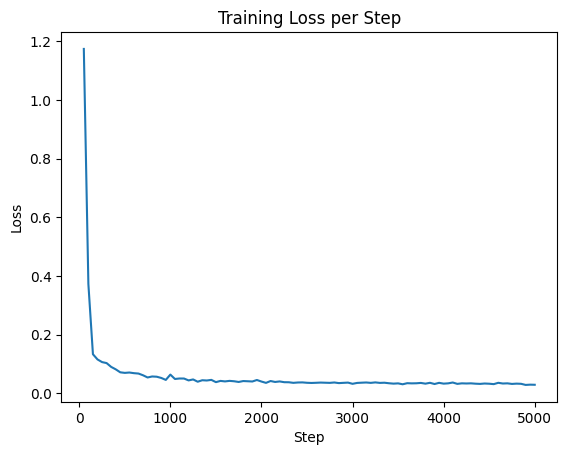

In [ ]:
import matplotlib.pyplot as plt

plt.plot(df["step"], df["loss"])
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss per Step")
plt.show()

In [ ]:
model.push_to_hub("nobara050/qwen2-T2C-lora-adapter")
tokenizer.push_to_hub("nobara050/qwen2-T2C-lora-adapter")

README.md:   0%|          | 0.00/594 [00:00<?, ?B/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...adapter_model.safetensors:  15%|#4        | 25.1MB /  168MB            

Saved model to https://huggingface.co/nobara050/llama3-T2C-lora-adapter


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...mpschylyvf/tokenizer.json: 100%|##########| 17.2MB / 17.2MB            

In [ ]:
# function keepAlive() {
#     const btn = document.querySelector("colab-connect-button") || document.querySelector("button[aria-label='Reconnect']");
#     if (btn) btn.click();
# }
# setInterval(keepAlive, 60000);